In [2]:
!pip install --quiet torchio
!pip install --quiet scikit-survival

import torch
import pickle
import pandas as pd
import numpy as np
import torchio as tio
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')
ROOT = "/content/gdrive/MyDrive/representation_learning/"

     |████████████████████████████████| 165 kB 15.7 MB/s 
     |████████████████████████████████| 48.4 MB 1.1 MB/s 
     |████████████████████████████████| 3.1 MB 15.4 MB/s 
Mounted at /content/gdrive


## function_dataset

In [3]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset


df_dataset = pd.read_csv(ROOT+"data/lung-01.csv")

match_table = {
    "I"   : 0,
    "II"  : 1,
    "IIIa": 2,
    "IIIb": 3
}

class TumorDataset(Dataset):
    
    def __init__(self, paths, transforms, task):
        
        self.paths = paths
        self.transforms = transforms
        self.task = task
    
    def __getitem__(self, idx):
        
        img_path = self.paths[idx]
        
        if self.task == "Overall_Stage":
            stage = match_table[df_dataset[df_dataset.PatientID == img_path[-13:-4]]["Overall.Stage"].tolist()[0]]
        elif self.task == "T_Stage":
            stage = int(df_dataset[df_dataset.PatientID == img_path[-13:-4]]["clinical.T.Stage"].tolist()[0]) - 1
        else:
            stage = 0
        
        img, mask, label, event = np.load(img_path, allow_pickle=True)
        img = img.astype(np.float32)

        if self.task == "train_Unet":
            mask = mask.astype(np.float32)
            data = {}
            data['image'] = torch.tensor(img, dtype = torch.float32).unsqueeze(0)
            data['mask'] = torch.tensor(mask, dtype = torch.float32).unsqueeze(0)
            transformed = self.transforms(data)
            img = transformed['image']
            mask = transformed['mask']
        else:
            img = self.transforms(torch.tensor(img, dtype = torch.float32).unsqueeze(0))
        stage = torch.tensor(stage, dtype = torch.long)
        return img, mask, label, event, stage
    
    def __len__(self):
        return len(self.paths)


## function_utils

In [4]:
import os
import gc
import torch
import random
import numpy as np
import pandas as pd

import torch.nn.functional as F
import torch.nn as nn

from collections import defaultdict
from tqdm import tqdm

from sksurv.metrics import concordance_index_censored

from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, confusion_matrix

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
class MetricMonitor:
    def __init__(self, float_precision=6):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val, bs):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += bs
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
        
def train_fn(model, train_loader, optimizer, device, epoch, criterion, task, history):
    
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Train ')
    metric_monitor = MetricMonitor()

    for step, (imgs, masks, label, event, stage) in pbar:

        batch_size = imgs.shape[0]
        
        if task == "T_Stage" or task == "Overall_Stage":
            stage = stage.to(device, dtype=torch.long)
            imgs = imgs.to(device, dtype=torch.float)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, stage)
        elif task == "Survival_Analysis":
            sorted_args = np.argsort(-label, axis=- 1, kind='mergesort')
            imgs = imgs[sorted_args,:, :, :].to(device, dtype=torch.float)
            label  = label[sorted_args].to(device, dtype=torch.float)
            event = event[sorted_args].to(device, dtype=torch.long)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, label, event, model)
        elif task == "train_Unet":
            imgs = imgs.to(device, dtype=torch.float)
            masks  = masks.to(device, dtype=torch.float)

            y_pred = model(imgs)
            loss = criterion(y_pred, masks)
        else:
            pass
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if task == "T_Stage" or task == "Overall_Stage":
            metric_monitor.update('CE', loss.item() * batch_size, batch_size)
            loss = metric_monitor.metrics['CE']['avg']
            history['CE'].append(loss)
        elif task == "Survival_Analysis":
            metric_monitor.update('NLL', loss.item() * batch_size, batch_size)
            loss = metric_monitor.metrics['NLL']['avg']
            history['NLL'].append(loss)
        elif task == "train_Unet":
            metric_monitor.update('loss', loss.item() * batch_size, batch_size)
            loss = metric_monitor.metrics['loss']['avg']
            history['loss'].append(loss)
        else:
            pass
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        pbar.set_description(f"Epoch: {epoch:02}. Train. {metric_monitor}")
        pbar.set_postfix(lr=optimizer.param_groups[0]['lr'],gpu_memory=f'{mem:0.2f} GB')
        
     
    torch.cuda.empty_cache()
    gc.collect()
    
    return loss

def evaluation_fn(model, test_loader, optimizer, device, epoch, criterion, task, history):
    
    model.eval()
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Validation ')
    metric_monitor = MetricMonitor()
    
    all_stage = []
    all_y_pred_proba = []
    all_y_pred = []
    all_label = []
    all_event = []

    with torch.no_grad():
        for step, (imgs, masks, label, event, stage) in pbar:

            batch_size = imgs.shape[0]
            
            if task == "T_Stage" or task == "Overall_Stage":
                stage = stage.to(device, dtype=torch.long)
                imgs = imgs.to(device, dtype=torch.float)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, stage)
                y_pred_proba = F.softmax(y_pred, dim=1)
                y_pred_class = torch.argmax(y_pred_proba, dim=1)
                stage = stage.cpu().data.numpy()
                for x in stage: all_stage.append(x)
                for x in y_pred_proba.cpu().data.numpy(): all_y_pred_proba.append(x)
                for x in y_pred_class.cpu().data.numpy(): all_y_pred.append(x)
                metric_monitor.update('CE', loss.item() * batch_size, batch_size)
                
            elif task == "Survival_Analysis":
                sorted_args = np.argsort(-label, axis = -1, kind='mergesort')
                imgs = imgs[sorted_args,:, :, :].to(device, dtype=torch.float)
                label  = label[sorted_args].to(device, dtype=torch.float)
                event = event[sorted_args].to(device, dtype=torch.long)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, label, event, model)
                y_pred = y_pred.cpu().data.numpy()
                label = label.cpu().data.numpy()
                event = event.cpu().data.numpy()
                for x in label: all_label.append(x)
                for x in event: all_event.append(x)
                for x in y_pred: all_y_pred.append(x[0])
                metric_monitor.update('NLL', loss.item() * batch_size, batch_size)

            elif task == "train_Unet":
                imgs = imgs.to(device, dtype=torch.float)
                masks  = masks.to(device, dtype=torch.float)
                y_pred = model(imgs)
                loss = criterion(y_pred, masks)
                dc = sum([dice_coef2(masks[i].detach().cpu().numpy(), (y_pred[i]>=0.5).detach().cpu().numpy()) for i in range(batch_size)])
                metric_monitor.update('loss', loss.item()*batch_size, batch_size)
                metric_monitor.update('DC', dc, batch_size)
            else:
                pass

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

            pbar.set_description(f"Epoch: {epoch:02}. ===> Eval. {metric_monitor}")
            pbar.set_postfix(lr=optimizer.param_groups[0]['lr'], gpu_memory=f'{mem:0.2f} GB')
        
        
        if task == "T_Stage" or task == "Overall_Stage":
            auc = roc_auc_score(all_stage, all_y_pred_proba, average="macro", multi_class='ovr')
            f1 = f1_score(all_stage, all_y_pred, average="macro")
            b_acc = balanced_accuracy_score(all_stage, all_y_pred)
            cm = confusion_matrix(all_stage, all_y_pred)
            class_scores = cm.diagonal()/cm.sum(axis=1)

            metric_monitor.update('AUC', auc * len(test_loader), len(test_loader))
            metric_monitor.update('F1', f1 * len(test_loader), len(test_loader))
            metric_monitor.update('B-ACC', b_acc * len(test_loader), len(test_loader))
            metric_monitor.update('C-ACC', class_scores * len(test_loader), len(test_loader))

            #print("\nAUC:", auc)
            #print("\nF1:", f1)
            #print("\nC-ACC:", class_scores)
            
            history['AUC'] = metric_monitor.metrics['AUC']['avg']
            history['F1'] = metric_monitor.metrics['F1']['avg']
            history['B-ACC'] = metric_monitor.metrics['B-ACC']['avg']
            history['C-ACC'] = metric_monitor.metrics['C-ACC']['avg']
            
            loss = metric_monitor.metrics['CE']['avg']
            
        elif task == "Survival_Analysis":
            events_bool = np.array(all_event) == 1.0
            CI = concordance_index_censored(events_bool, all_label, all_y_pred)[0]
            #print("\nCI:", CI)
            metric_monitor.update('CI', CI * len(test_loader), len(test_loader))
            history["NLL"] = metric_monitor.metrics['NLL']['avg']
            history["CI"] = metric_monitor.metrics['CI']['avg']
            
            loss = metric_monitor.metrics['NLL']['avg']

        elif task == "train_Unet":
            history["loss"] = metric_monitor.metrics['loss']['avg']
            history["DC"] = metric_monitor.metrics['DC']['avg']

        else:
            pass
        torch.cuda.empty_cache()
        gc.collect()

        return loss
  
class Regularization(object):
    def __init__(self, order, wd):
        ''' The initialization of Regularization class
        :param order: (int) norm order number
        :param weight_decay: (float) weight decay rate
        '''
        super(Regularization, self).__init__()
        self.order = order
        self.wd = wd

    def __call__(self, model):
        ''' Performs calculates regularization(self.order) loss for model.
        :param model: (torch.nn.Module object)
        :return reg_loss: (torch.Tensor) the regularization(self.order) loss
        '''
        reg_loss = 0
        for name, w in model.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(w, p=self.order)
        reg_loss = self.wd * reg_loss
        return reg_loss

class NegativeLogLikelihood(nn.Module):
    def __init__(self,  wd = 0):
        super(NegativeLogLikelihood, self).__init__()
        self.reg = Regularization(order=2, wd=wd)

    def forward(self, risk_pred, y, e, model):
        log_loss = torch.exp(risk_pred)
        log_loss = torch.cumsum(log_loss, dim=0)
        log_loss = torch.log(log_loss).reshape(-1, 1)
        neg_log_loss = - torch.sum((risk_pred-log_loss) * e) / (torch.sum(e) + 1)
        l2_loss = self.reg(model)
        return neg_log_loss + l2_loss

def bootstrapping_fn(cfg, task, model_name, pretrained, wce, model, path_test, val_transform, criterion, optimizer):

    model.eval()
    n = len(path_test)
    
    auc_scores = []
    f1_scores = []
    bacc_scores = []
    cacc_scores = []
    ci_scores = []

    for i in tqdm(range(500)):

        idx_boot = np.random.choice(list(range(n)), size = n, replace = True)
        test_boot = [path_test[x] for x in idx_boot]
        test_boot = TumorDataset(test_boot, transforms=val_transform, task=task)
        test_loader = DataLoader(test_boot, shuffle=True, batch_size=cfg["batch_size"], num_workers=cfg["n_workers"])

        with torch.no_grad():

            metric_monitor = MetricMonitor()
            all_stage = []
            all_y_pred_proba = []
            all_y_pred = []
            all_label = []
            all_event = []
            
            for step, (imgs, mask, label, event, stage) in enumerate(test_loader):
                batch_size = imgs.shape[0]

                if task == "T_Stage" or task == "Overall_Stage":
                    stage = stage.to(cfg["device"], dtype=torch.long)
                    imgs = imgs.to(cfg["device"], dtype=torch.float)
                    
                    y_pred = model(imgs)
                    loss = criterion(y_pred, stage)
                    y_pred_proba = F.softmax(y_pred, dim=1)
                    y_pred_class = torch.argmax(y_pred_proba, dim=1)
                    stage = stage.cpu().data.numpy()
                    for x in stage: all_stage.append(x)
                    for x in y_pred_proba.cpu().data.numpy(): all_y_pred_proba.append(x)
                    for x in y_pred_class.cpu().data.numpy(): all_y_pred.append(x)
                    
                elif task == "Survival_Analysis":
                    sorted_args = np.argsort(-label, axis=- 1, kind='mergesort')
                    imgs = imgs[sorted_args,:, :, :].to(cfg["device"], dtype=torch.float)
                    label  = label[sorted_args].to(cfg["device"], dtype=torch.float)
                    event = event[sorted_args].to(cfg["device"], dtype=torch.long)
                    
                    y_pred = model(imgs)
                    loss = criterion(y_pred, label, event, model)
                    y_pred = y_pred.cpu().data.numpy()
                    label = label.cpu().data.numpy()
                    event = event.cpu().data.numpy()
                    for x in label: all_label.append(x)
                    for x in event: all_event.append(x)
                    for x in y_pred: all_y_pred.append(x[0])
                else:
                    pass
        
        if task == "T_Stage" or task == "Overall_Stage":
            auc = roc_auc_score(all_stage, all_y_pred_proba, average="macro", multi_class='ovr')
            f1 = f1_score(all_stage, all_y_pred, average="macro")
            b_acc = balanced_accuracy_score(all_stage, all_y_pred)
            cm = confusion_matrix(all_stage, all_y_pred)
            class_scores = cm.diagonal()/cm.sum(axis=1)

            auc_scores.append(auc)
            f1_scores.append(f1)
            bacc_scores.append(b_acc)
            cacc_scores.append(class_scores)
                        
        elif task == "Survival_Analysis":
            events_bool = np.array(all_event) == 1.0
            CI = concordance_index_censored(events_bool, all_label, all_y_pred)[0]
            ci_scores.append(CI)
        else:
            pass

        torch.cuda.empty_cache()
        gc.collect()

    if task == "Survival_Analysis":
        test_history = {'NLL': [],'CI': []}
    else:
        test_history = {'CE': [],'AUC': [], 'F1':[], 'B-ACC':[], 'C-ACC':[]}
    val_loss = evaluation_fn(model, test_loader, optimizer, cfg["device"], 0, criterion, task, test_history)

    if task == "T_Stage" or task == "Overall_Stage":
        return pd.DataFrame([{
              "model": model_name,
              "pretrained": pretrained,
              "wce": wce,
              "cfg": cfg,
              "Mean ROC-AUC":  np.mean(auc_scores),
              "Min ROC-AUC":  np.min(sorted(auc_scores)[12:488]),
              "Max ROC-AUC":  np.max(sorted(auc_scores)[12:488]),
              "Mean F1":  np.mean(f1_scores),
              "Min F1":  np.min(sorted(f1_scores)[12:488]),
              "Max F1":  np.max(sorted(f1_scores)[12:488]),
              "Mean Balanced ACC": np.mean(bacc_scores),
              "Min Balanced ACC": np.min(sorted(bacc_scores)[12:488]),
              "Max Balanced ACC": np.max(sorted(bacc_scores)[12:488]),
              "MEAN CLASSES":  np.mean(cacc_scores, axis=0),
              "min c1" : np.min(sorted(np.array(cacc_scores).T[0])[12:488]),
              "max c1" : np.max(sorted(np.array(cacc_scores).T[0])[12:488]),
              "min c2" : np.min(sorted(np.array(cacc_scores).T[1])[12:488]),
              "max c2" : np.max(sorted(np.array(cacc_scores).T[1])[12:488]),
              "min c3" : np.min(sorted(np.array(cacc_scores).T[2])[12:488]),
              "max c3" : np.max(sorted(np.array(cacc_scores).T[2])[12:488]),
              "min c4" : np.min(sorted(np.array(cacc_scores).T[3])[12:488]),
              "max c4" : np.max(sorted(np.array(cacc_scores).T[3])[12:488]),
              "whole test set CE": val_loss,
              "whole test set AUC": test_history["AUC"],
              "whole test set F1": test_history["F1"],
              "whole test set B-ACC": test_history["B-ACC"],
              "whole test set C-ACC": test_history["C-ACC"]
              }])
    elif task == "Survival_Analysis":
        return pd.DataFrame([{
              "model": model_name,
              "pretrained": pretrained,
              "wce": wce,
              "cfg": cfg,
              "Mean CI":  np.mean(ci_scores),
              "Min CI":  np.min(sorted(ci_scores)[12:488]),
              "Max CI":  np.max(sorted(ci_scores)[12:488]),
              "whole test set NLL": val_loss,
              "whole test set CI": test_history["CI"]
              }])
    else:
      pass

## function_models

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial

class CustomNetwork(nn.Module):
    def __init__(self, task, pdropout):
        super(CustomNetwork, self).__init__()

        n = 1 if task == "Survival_Analysis" else 4

        self.network = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=64, kernel_size=5, padding=0, stride=1),
            nn.Dropout(pdropout),
            nn.ReLU(),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
            nn.Dropout(pdropout),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=3),
            nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
            nn.Dropout(pdropout),
            nn.ReLU(),
            nn.Conv3d(in_channels=256, out_channels=64, kernel_size=3, padding=0, stride=1),
            nn.Dropout(pdropout),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=3),
            nn.Flatten(),
            nn.Linear(61952, 512),
            nn.Dropout(pdropout),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(pdropout),
            nn.ReLU(),
            nn.Linear(256, n),
        )
   
    def forward(self, x):
        return self.network(x)


def downsample_basic_block(x, planes, stride, no_cuda=False):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if not no_cuda:
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(inplanes,
                                planes,
                                kernel_size=3,
                                dilation=dilation,
                                stride=stride,
                                padding=dilation,
                                bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes,
                                planes,
                                kernel_size=3,
                                dilation=dilation,
                                stride=1,
                                padding=dilation,
                                bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, dilation=dilation, padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,block,layers,shortcut_type='B',no_cuda = False):
        self.inplanes = 64
        self.no_cuda = no_cuda
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(1,64,kernel_size=7,stride=(2, 2, 2),padding=(3, 3, 3),bias=False) 
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], shortcut_type, stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], shortcut_type, stride=1, dilation=4)

        self.conv_seg = nn.Sequential(
                                    nn.ConvTranspose3d(512*block.expansion,32,2,stride=2),
                                    nn.BatchNorm3d(32),
                                    nn.ReLU(inplace=True),
                                    nn.Conv3d(32,32,kernel_size=3,stride=(1, 1, 1),padding=(1, 1, 1),bias=False), 
                                    nn.BatchNorm3d(32),
                                    nn.ReLU(inplace=True),
                                    nn.Conv3d(32,2,kernel_size=1,stride=(1, 1, 1),bias=False) 
                                    )

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride,
                    no_cuda=self.no_cuda)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.conv_seg(x)

        return x

class CustomResnet(nn.Module):
    def __init__(self, task, model, pretrained, dropout):
        super(CustomResnet, self).__init__()
        if model == "resnet34":
            self.resnet = ResNet(BasicBlock, [3, 4, 6, 3])
        elif model == "resnet101":
            self.resnet = ResNet(Bottleneck, [3, 4, 23, 3])
        else:
            pass
        
        if pretrained == True:
            net_dict = self.resnet.state_dict()
            if model == "resnet34":
                pretrain = torch.load(ROOT+"pretrained_resnet/resnet_34.pth")
            elif model == "resnet101":
                pretrain = torch.load(ROOT+"pretrained_resnet/resnet_101.pth")
            else:
                pass
            pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
            net_dict.update(pretrain_dict)
            self.resnet.load_state_dict(net_dict)

            for param in self.resnet.parameters():
                param.requires_grad = False

        self.flattening = nn.Flatten()
        self.dropout1 = nn.Dropout(dropout)
        self.fcl1 = nn.Linear(53760, 1000)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        n = 1 if task == "Survival_Analysis" else 4

        self.fcl2 = nn.Linear(1000, n)
        
        
    def forward(self, x):

        x = self.resnet(x)
        x = self.flattening(x)
        x = self.dropout1(x)
        x = self.fcl1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.fcl2(x)
        
        return x



def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y



class Unet3D(nn.Module):
    def __init__(self,
                 task,
                 in_channels: int = 1,
                 out_channels: int = 1,
                 n_blocks: int = 3,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 3,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()
        self.task = task
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)
        
        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)
        self.sigmo = nn.Sigmoid()
        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()
        
    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        
        if self.task != "train_Unet":
            for module in self.down_blocks:
                x, before_pooling = module(x)
        else:
            encoder_output = []
            # Encoder pathway
            for module in self.down_blocks:
                x, before_pooling = module(x)
                encoder_output.append(before_pooling)

            # Decoder pathway
            for i, module in enumerate(self.up_blocks):
                before_pool = encoder_output[-(i + 2)]
                x = module(before_pool, x)

            x = self.conv_final(x)
            x = self.sigmo(x)
       
        return x


class CustomUnet(nn.Module):
    def __init__(self, task, dropout):
        super(CustomUnet, self).__init__()
        self.unet = Unet3D(task=task)
        self.unet.load_state_dict(torch.load(ROOT+"data/weights/train_Unet_Unet_pretrained_False_WCE_False.pt"))

        for param in self.unet.parameters():
            param.requires_grad = False

        self.convBlock = nn.Conv3d(128, 1, kernel_size = 3, stride = 2)
        
        self.flattening = nn.Flatten()
        self.dropout1 = nn.Dropout(dropout)
        self.fcl1 = nn.Linear(2646, 1000)
        self.leakyrelu1 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fcl2 = nn.Linear(1000, 100)
        self.leakyrelu2 = nn.LeakyReLU()
        n = 1 if task == "Survival_Analysis" else 4
        self.fcl3 = nn.Linear(100, n)
        
        
    def forward(self, x):

        x = self.unet(x)
        x = self.convBlock(x)
        x = self.flattening(x)
        x = self.dropout1(x)
        x = self.fcl1(x)
        x = self.leakyrelu1(x)
        x = self.dropout2(x)
        x = self.fcl2(x)
        x = self.leakyrelu2(x)
        x = self.fcl3(x)
        
        return x

## function_Unet

In [6]:
def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.
    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))



class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify `normalization=Softmax`
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        # average Dice score across all channels/classes
        return 1. - torch.mean(per_channel_dice)


class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    The input to the loss function is assumed to be a logit and will be normalized by the Sigmoid function.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super().__init__(weight, normalization)

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)



def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

class Dice_BCE(nn.Module):
  def __init__(self):
    super().__init__()
    self.dl =  DiceLoss(weight=None, normalization='sigmoid')
    self.bce = nn.BCELoss()
  def forward(self, pred, true):

    return 2*self.bce(pred, true) + self.dl(pred, true)

def plotExample(model, path_train, idx=-12):

    img_path = path_train[idx]
        
    img, mask, label, event = np.load(img_path, allow_pickle=True)
    
    img = torch.tensor(img, dtype = torch.float32).unsqueeze(0)
    mask = torch.tensor(mask, dtype = torch.int64).unsqueeze(0)

    pred = model(img.to(cfg['device'], torch.float).unsqueeze(0))
    pred = pred.cpu().detach().numpy().squeeze(0).squeeze(0)
    img = img.squeeze(0)
    mask = mask.squeeze(0)
    f, axs = plt.subplots(1,3, figsize = (10,5))
    axs[0].imshow(pred[30,:,:])
    axs[1].imshow(img[30,:,:])
    axs[2].imshow(mask[30,:,:])

    plt.show()

    f, axs = plt.subplots(1,3, figsize = (10,5))
    axs[0].imshow(pred[:,30,:])
    axs[1].imshow(img[:,30,:])
    axs[2].imshow(mask[:,30,:])

    plt.show()


    f, axs = plt.subplots(1,3, figsize = (10,5))
    axs[0].imshow(pred[:,:,30])
    axs[1].imshow(img[:,:,30])
    axs[2].imshow(mask[:,:,30])

    plt.show()


## main loop

In [7]:
def main(cfg, task, model_name, pretrained, wce):
    df = pd.read_csv(ROOT+"data/train_test_kfold.csv")
    df = df[df.PatiendID != 128]

    if task == "Overall_Stage":
        df = df[df.PatiendID != 272]
    if task == "T_Stage":
        df = df[df.PatiendID != 56]
        df = df[df.PatiendID != 272]
        df = df[df.PatiendID != 85]
    else:
        pass

    index_train = df[df.FOLD2 == 1]
    index_val = df[df.FOLD2 == 0]
    index_test = df[df.FOLD2 == -1]
    path_train = [ROOT + f"data/dataset/LUNG1-{x:03}.npy" for x in index_train.PatiendID.tolist()]
    path_test = [ROOT + f"data/dataset/LUNG1-{x:03}.npy" for x in index_test.PatiendID.tolist()]
    path_val = [ROOT + f"data/dataset/LUNG1-{x:03}.npy" for x in index_val.PatiendID.tolist()]
        
    df = pd.read_csv(ROOT+"data/lung-01.csv")

    set_seed(cfg["seed"])
    if task == "train_Unet":
        train_transform = tio.Compose([
                          tio.RandomAffine(include = ['image', 'mask']),
                          tio.RandomFlip(flip_probability=0.5, include = ['image', 'mask']),
                          tio.RandomNoise(std=0.5, include = ['image']),
                          tio.RandomBlur(include = ['image'])])
        val_transform = tio.Compose([])
    else:
        train_transform = tio.Compose([
                              tio.RandomAffine(),
                              tio.RandomFlip(flip_probability=0.5),
                              tio.RandomNoise(std=0.5)])
        val_transform = tio.Compose([])

    train_set = TumorDataset(path_train, transforms=train_transform, task=task)
    train_loader = DataLoader(train_set, shuffle=True, batch_size=cfg["batch_size"], num_workers=cfg["n_workers"])

    val_set = TumorDataset(path_val, transforms=val_transform, task=task)
    val_loader = DataLoader(val_set, shuffle=True, batch_size=cfg["batch_size"], num_workers=cfg["n_workers"])

    test_set = TumorDataset(path_test, transforms=val_transform, task=task)
    test_loader = DataLoader(test_set, shuffle=True, batch_size=cfg["batch_size"], num_workers=cfg["n_workers"])

    if task == "train_Unet":
        model = Unet3D(task=task).to(cfg["device"])
    elif model_name == "CNN":
        model = CustomNetwork(task, 0.3).to(cfg["device"])
    elif model_name == "resnet34" or model_name == "resnet101":
        model = CustomResnet(task, model_name, pretrained, 0.3).to(cfg["device"])
    elif model_name == "Unet":
        model = CustomUnet(task, 0.1).to(cfg["device"])
    else:
        pass

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = cfg["gamma"])

    if task == "Survival_Analysis":
        train_history = {'NLL': []}
        val_history = {'NLL': [],'CI': []}
        criterion = NegativeLogLikelihood(wd = 0.1)
    elif task == "Overall_Stage" or task == "T_Stage":
        train_history = {'CE': []}
        val_history = {'CE': [],'AUC': [], 'F1':[], 'B-ACC':[], 'C-ACC':[]}
        if wce == True:
            if task == "Overall_Stage":
                inv_weights = 1 / df['Overall.Stage'].value_counts().sort_index().values[:]
            else:
                inv_weights = 1 / df['clinical.T.Stage'].value_counts().sort_index().values[:4]
            inv_weights /= np.sum(inv_weights)
            criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(inv_weights).to(cfg["device"]))
        else:
            criterion = nn.CrossEntropyLoss()
    elif task == "train_Unet":
        train_history = { 'loss': []}
        val_history = {'loss': [], 'DC': []}
        criterion = Dice_BCE()
    else:
        pass
        
    NAME = "{}_{}_pretrained_{}_WCE_{}".format(task, model_name, pretrained, wce)

    best_loss = float('inf')
    best_epoch = 0
    counter_es = 0
    
    for epoch in range(cfg['n_epochs']):
      
        train_loss = train_fn(model, train_loader, optimizer, cfg["device"], epoch, criterion, task, train_history)
        val_loss = evaluation_fn(model, val_loader, optimizer, cfg["device"], epoch, criterion, task, val_history)

        scheduler.step()

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            counter_es = 0
            torch.save(model.state_dict(), ROOT+"data/weights/"+NAME+".pt")
        else:
            counter_es +=1


        with open(ROOT+'data/logs/'+NAME+'_train.pickle', 'wb') as handle:
            pickle.dump(train_history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(ROOT+'data/logs/'+NAME+'_val.pickle', 'wb') as handle:
            pickle.dump(val_history, handle, protocol=pickle.HIGHEST_PROTOCOL)


        if counter_es == cfg["counter_es"]:
            break

        if task == "train_Unet":
            plotExample(model, path_train)

    model.load_state_dict(torch.load(ROOT+"data/weights/"+NAME+".pt"))
    if task != "train_Unet":
        boot_df = bootstrapping_fn(cfg, task, model_name, pretrained, wce, model, path_test, val_transform, criterion, optimizer)
        boot_df.to_csv(ROOT+task+".csv", mode='a', header=True)

## Action here

> SEEDING DONE


Epoch: 00. Train. loss: 1.889272: 100%|██████████| 135/135 [01:29<00:00,  1.51it/s, gpu_memory=9.27 GB, lr=0.001]
Epoch: 00. ===> Eval. loss: 1.467618 | DC: 0.002172: 100%|██████████| 34/34 [00:07<00:00,  4.56it/s, gpu_memory=4.44 GB, lr=0.001]


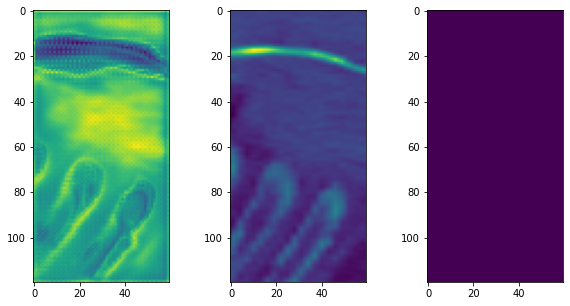

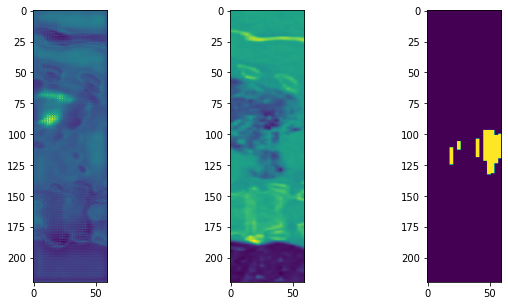

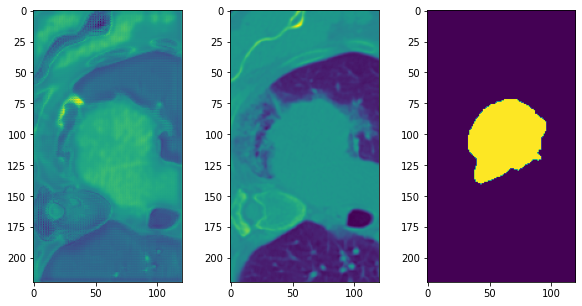

Epoch: 01. Train. loss: 1.305829: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.00095]
Epoch: 01. ===> Eval. loss: 1.244585 | DC: 0.000140: 100%|██████████| 34/34 [00:05<00:00,  6.06it/s, gpu_memory=4.46 GB, lr=0.00095]


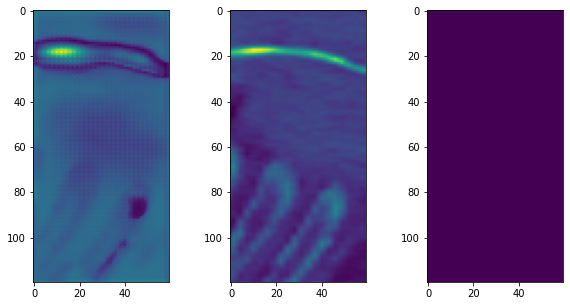

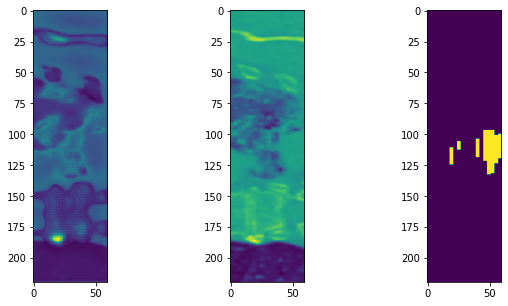

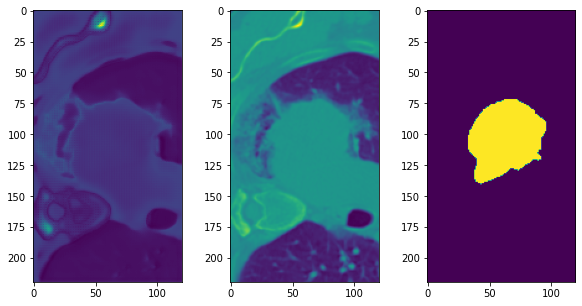

Epoch: 02. Train. loss: 1.166083: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000902]
Epoch: 02. ===> Eval. loss: 1.353085 | DC: 0.194925: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s, gpu_memory=4.46 GB, lr=0.000902]


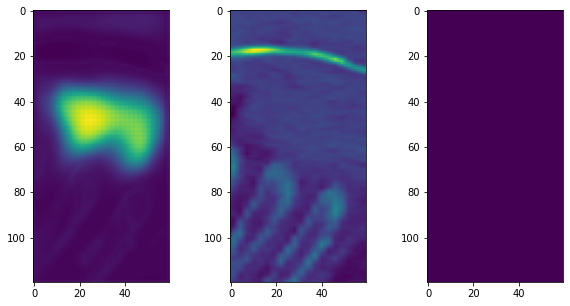

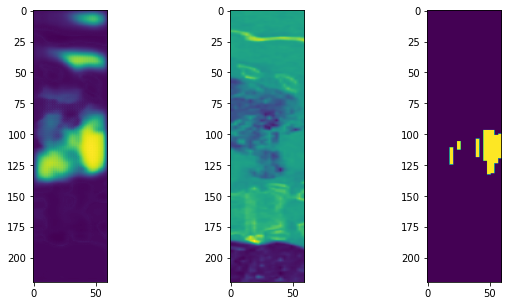

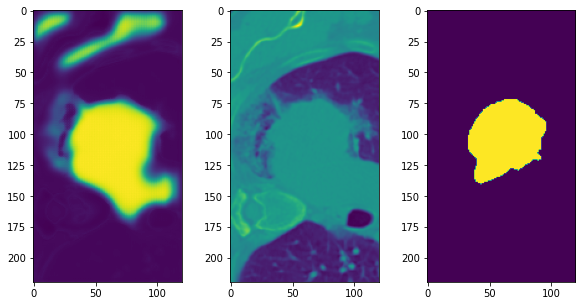

Epoch: 03. Train. loss: 1.127710: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000857]
Epoch: 03. ===> Eval. loss: 1.167866 | DC: 0.015861: 100%|██████████| 34/34 [00:05<00:00,  6.03it/s, gpu_memory=4.46 GB, lr=0.000857]


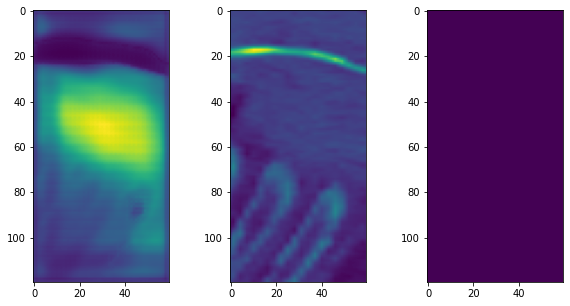

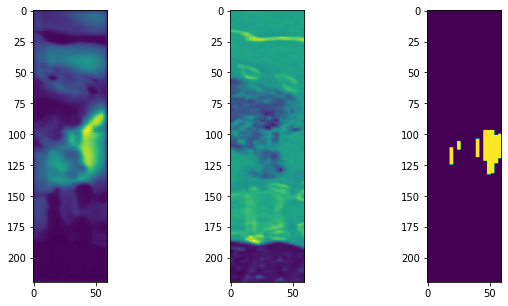

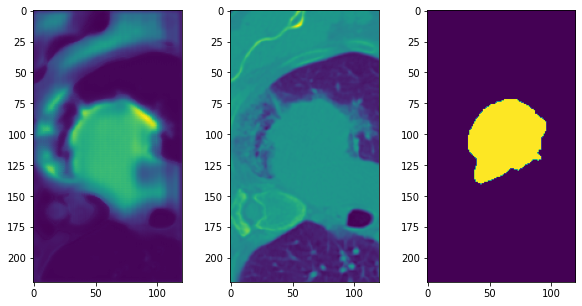

Epoch: 04. Train. loss: 1.113854: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000815]
Epoch: 04. ===> Eval. loss: 1.143025 | DC: 0.175119: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s, gpu_memory=4.46 GB, lr=0.000815]


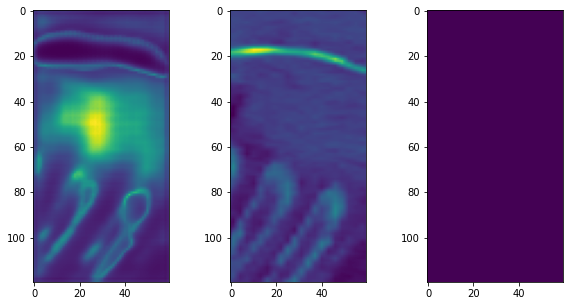

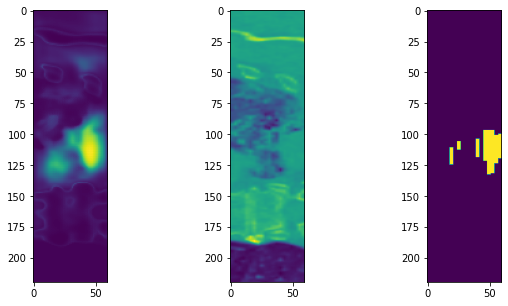

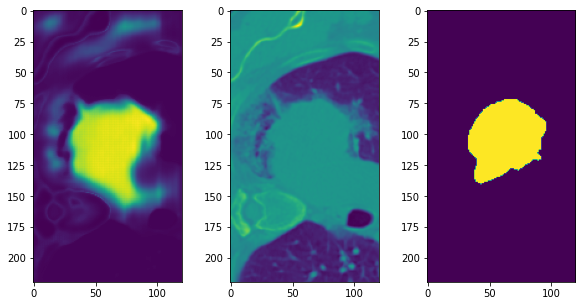

Epoch: 05. Train. loss: 1.116789: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.38 GB, lr=0.000774]
Epoch: 05. ===> Eval. loss: 1.120463 | DC: 0.195997: 100%|██████████| 34/34 [00:05<00:00,  6.00it/s, gpu_memory=4.46 GB, lr=0.000774]


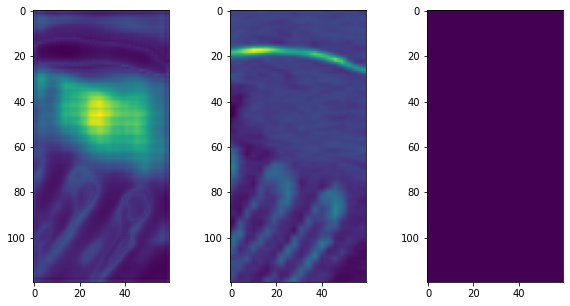

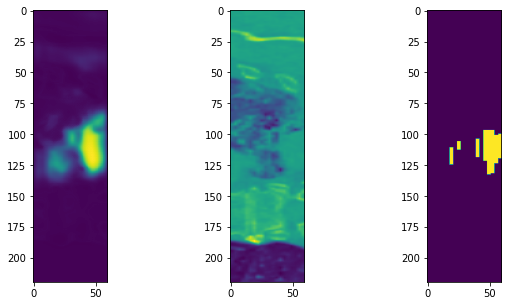

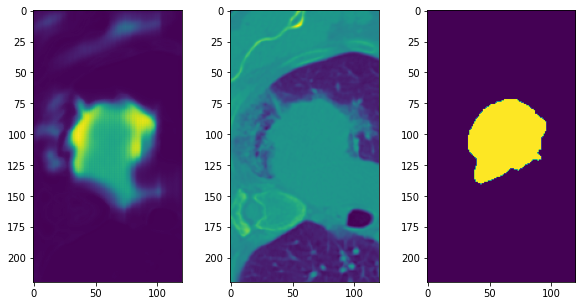

Epoch: 06. Train. loss: 1.101704: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000735]
Epoch: 06. ===> Eval. loss: 1.142983 | DC: 0.024239: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s, gpu_memory=4.46 GB, lr=0.000735]


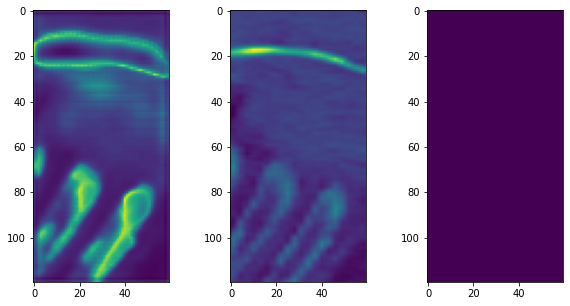

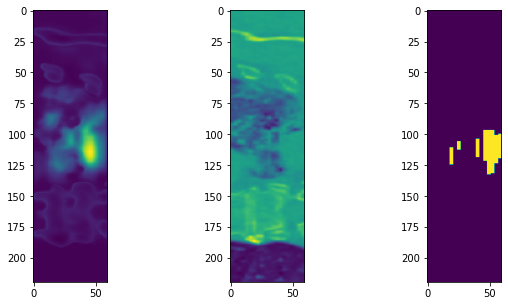

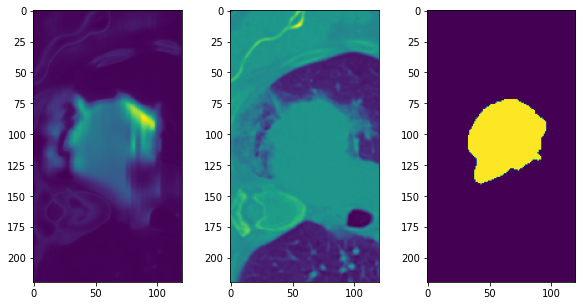

Epoch: 07. Train. loss: 1.095256: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000698]
Epoch: 07. ===> Eval. loss: 1.119172 | DC: 0.139583: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s, gpu_memory=4.46 GB, lr=0.000698]


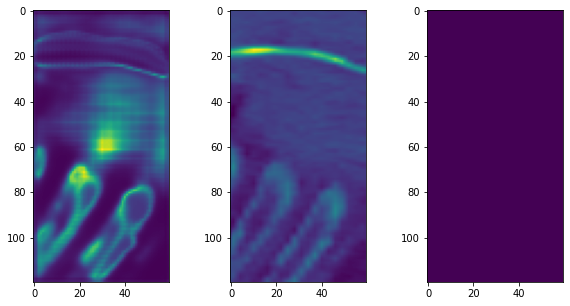

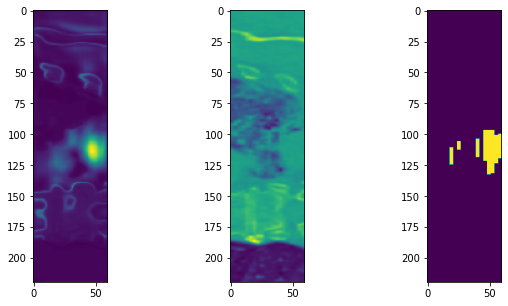

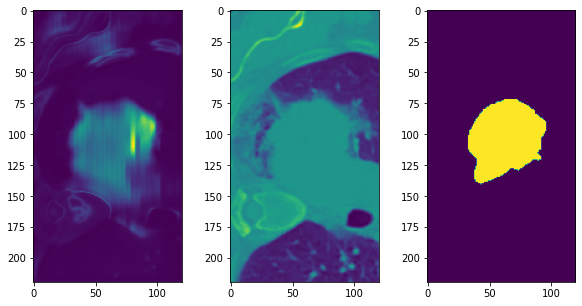

Epoch: 08. Train. loss: 1.089056: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000663]
Epoch: 08. ===> Eval. loss: 1.105684 | DC: 0.146809: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s, gpu_memory=4.46 GB, lr=0.000663]


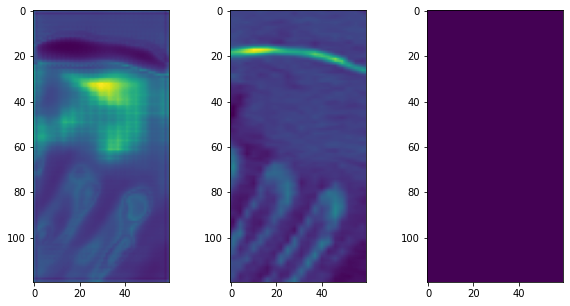

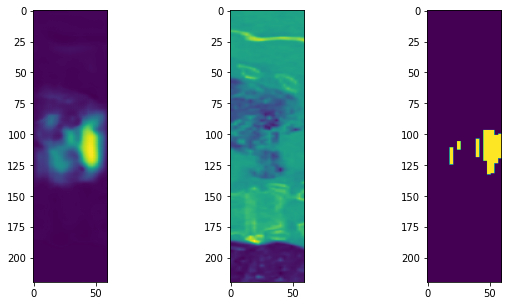

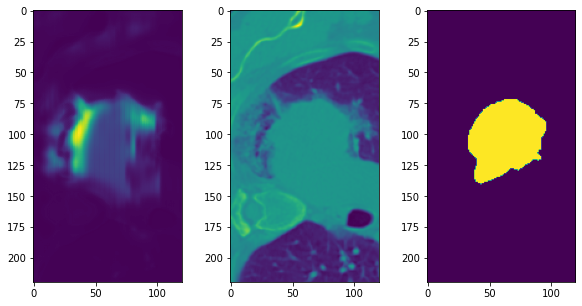

Epoch: 09. Train. loss: 1.079651: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.00063]
Epoch: 09. ===> Eval. loss: 1.071741 | DC: 0.285620: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s, gpu_memory=4.46 GB, lr=0.00063]


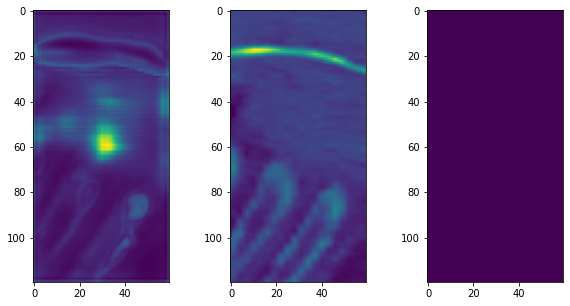

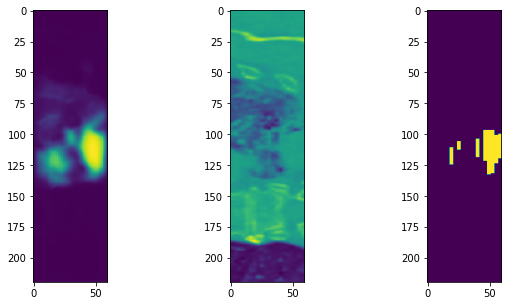

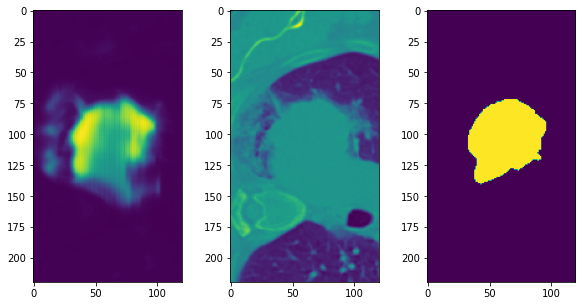

Epoch: 10. Train. loss: 1.072122: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000599]
Epoch: 10. ===> Eval. loss: 1.101396 | DC: 0.229074: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s, gpu_memory=4.46 GB, lr=0.000599]


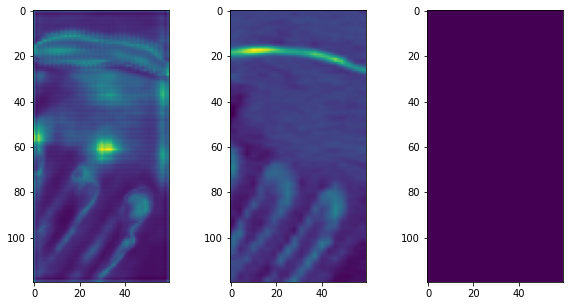

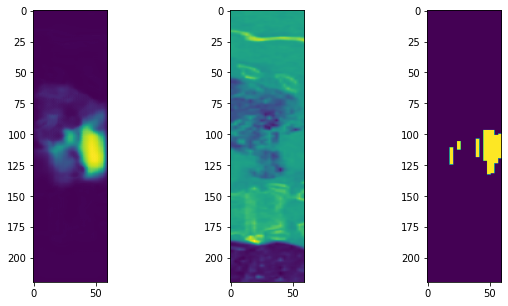

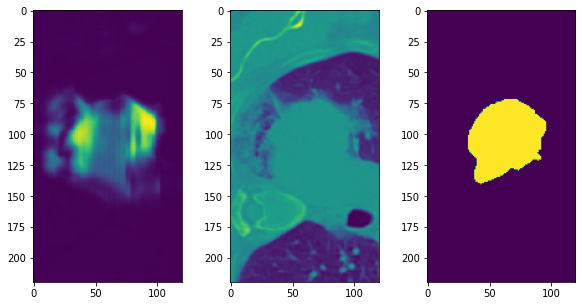

Epoch: 11. Train. loss: 1.066401: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000569]
Epoch: 11. ===> Eval. loss: 1.076807 | DC: 0.231599: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s, gpu_memory=4.46 GB, lr=0.000569]


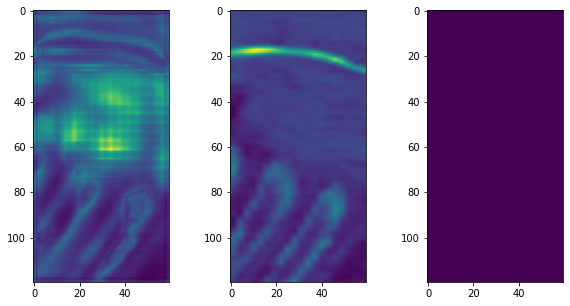

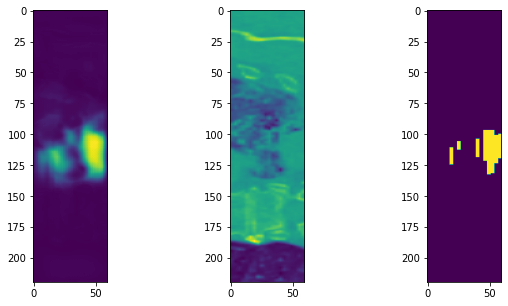

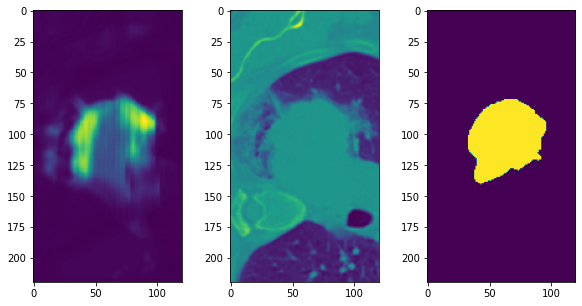

Epoch: 12. Train. loss: 1.064594: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.00054]
Epoch: 12. ===> Eval. loss: 1.074543 | DC: 0.342320: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s, gpu_memory=4.46 GB, lr=0.00054]


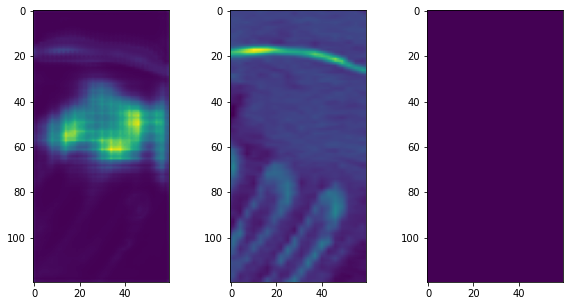

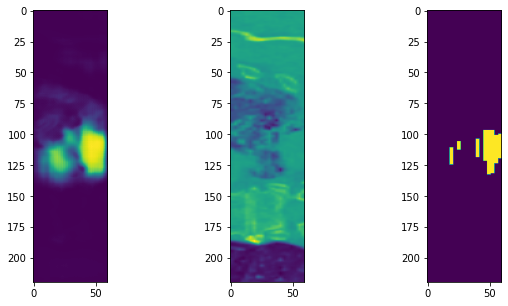

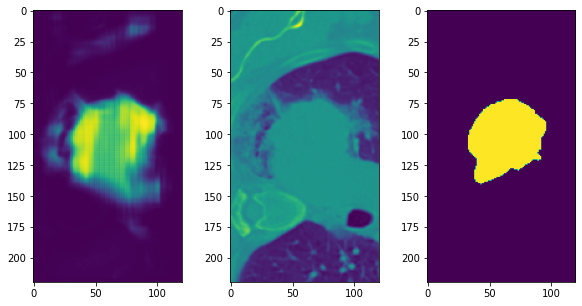

Epoch: 13. Train. loss: 1.061502: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000513]
Epoch: 13. ===> Eval. loss: 1.067308 | DC: 0.371894: 100%|██████████| 34/34 [00:05<00:00,  6.01it/s, gpu_memory=4.46 GB, lr=0.000513]


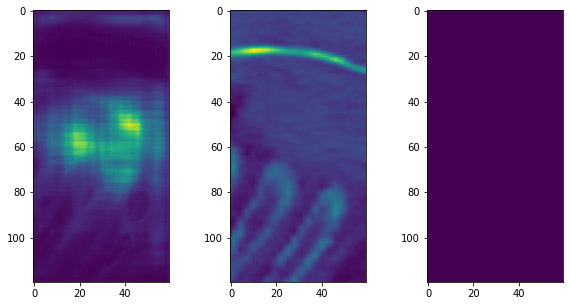

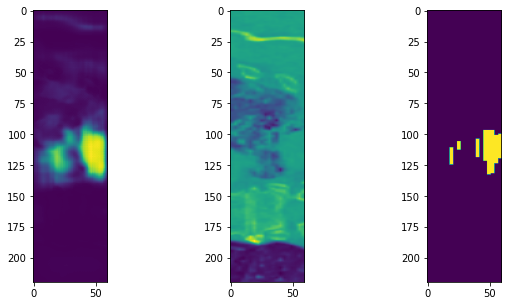

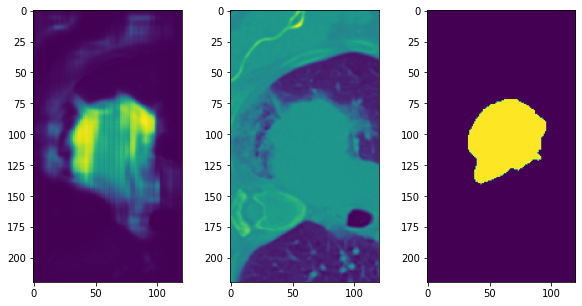

Epoch: 14. Train. loss: 1.060609: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000488]
Epoch: 14. ===> Eval. loss: 1.111069 | DC: 0.141821: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s, gpu_memory=4.46 GB, lr=0.000488]


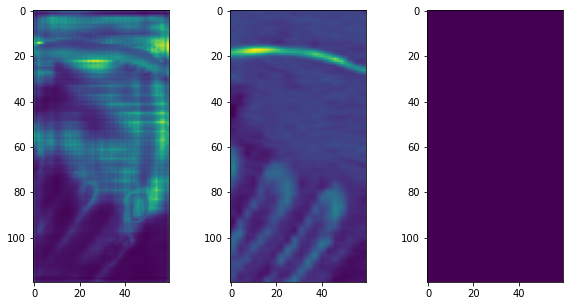

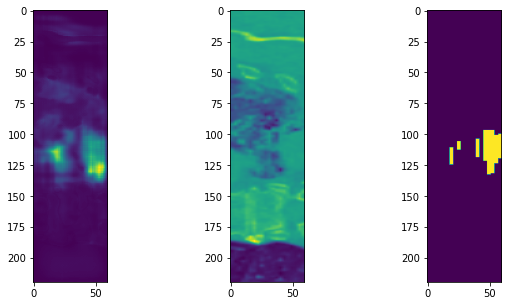

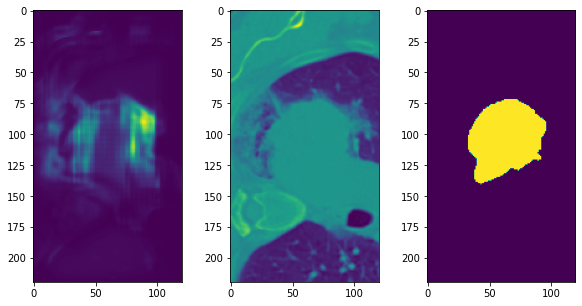

Epoch: 15. Train. loss: 1.047698: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000463]
Epoch: 15. ===> Eval. loss: 1.055534 | DC: 0.297046: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s, gpu_memory=4.46 GB, lr=0.000463]


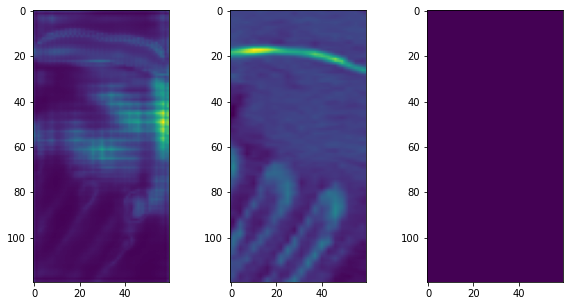

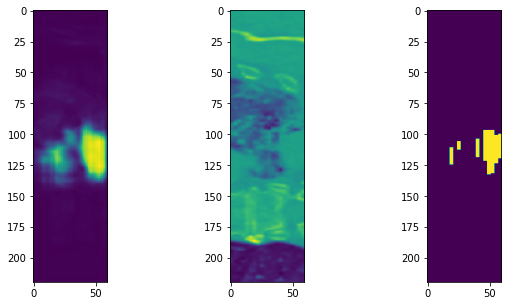

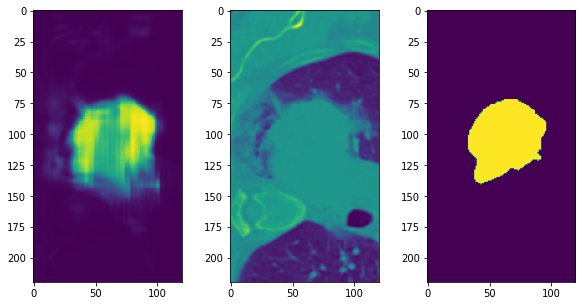

Epoch: 16. Train. loss: 1.044325: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.00044]
Epoch: 16. ===> Eval. loss: 1.074107 | DC: 0.197334: 100%|██████████| 34/34 [00:05<00:00,  6.05it/s, gpu_memory=4.46 GB, lr=0.00044]


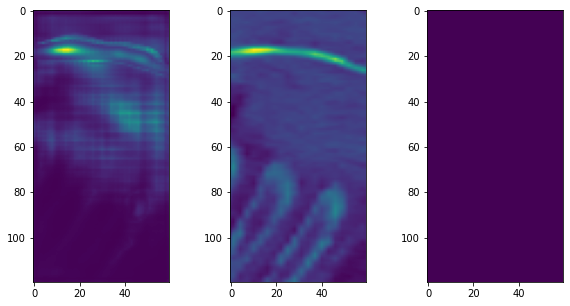

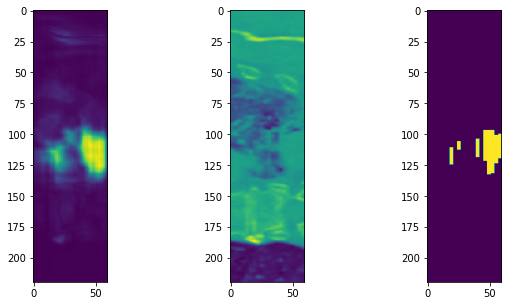

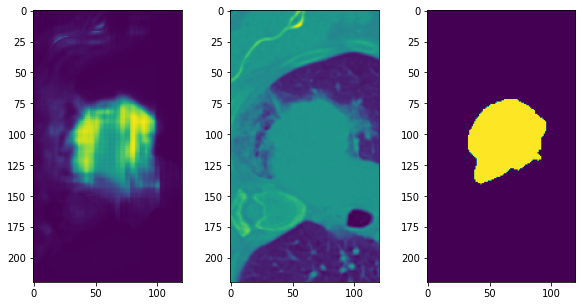

Epoch: 17. Train. loss: 1.047447: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000418]
Epoch: 17. ===> Eval. loss: 1.089623 | DC: 0.271108: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s, gpu_memory=4.46 GB, lr=0.000418]


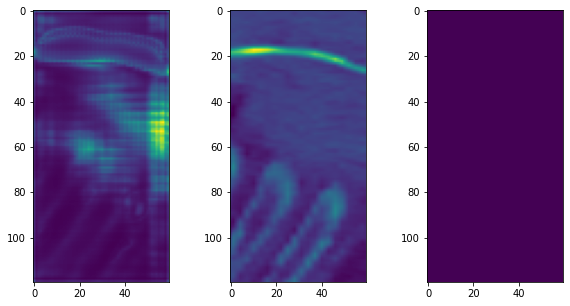

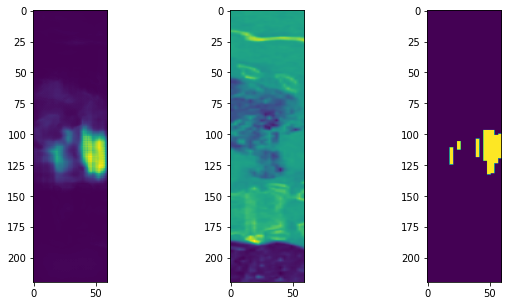

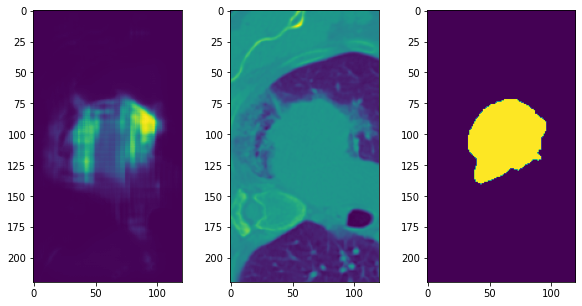

Epoch: 18. Train. loss: 1.042497: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000397]
Epoch: 18. ===> Eval. loss: 1.058722 | DC: 0.271494: 100%|██████████| 34/34 [00:05<00:00,  6.06it/s, gpu_memory=4.46 GB, lr=0.000397]


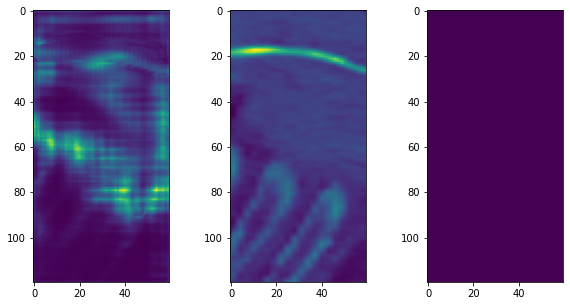

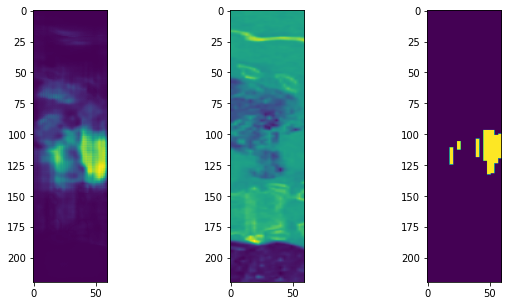

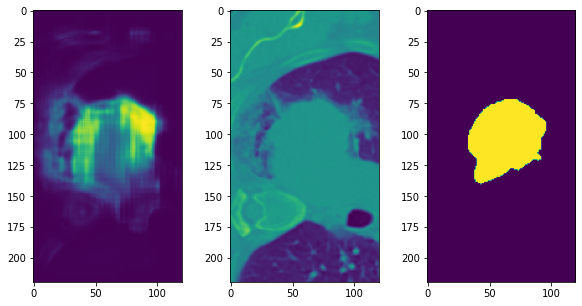

Epoch: 19. Train. loss: 1.039800: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000377]
Epoch: 19. ===> Eval. loss: 1.065881 | DC: 0.238311: 100%|██████████| 34/34 [00:05<00:00,  6.02it/s, gpu_memory=4.46 GB, lr=0.000377]


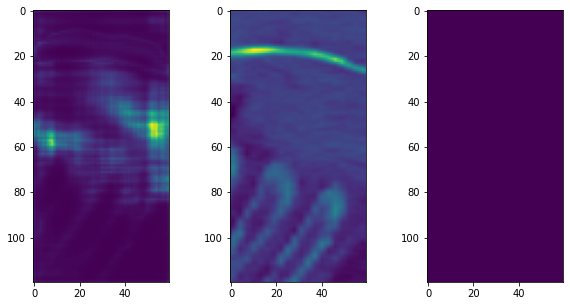

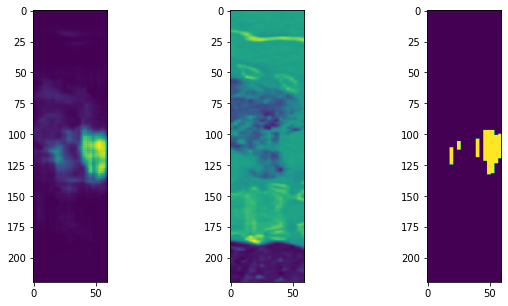

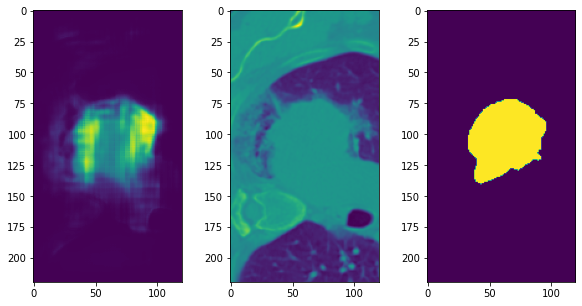

Epoch: 20. Train. loss: 1.033541: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000358]
Epoch: 20. ===> Eval. loss: 1.047001 | DC: 0.323843: 100%|██████████| 34/34 [00:05<00:00,  6.01it/s, gpu_memory=4.46 GB, lr=0.000358]


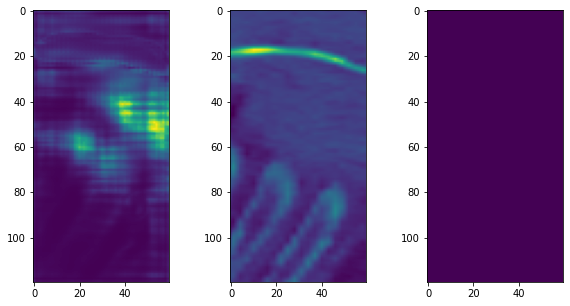

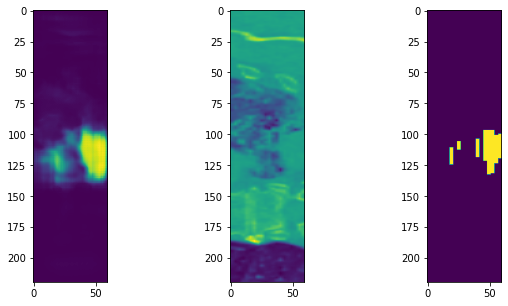

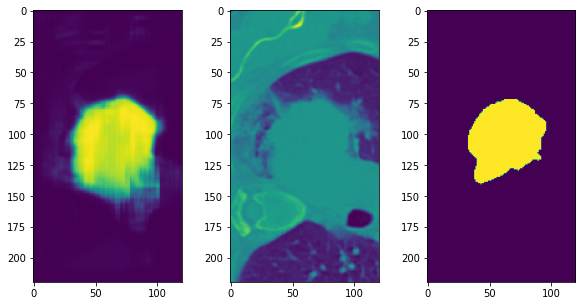

Epoch: 21. Train. loss: 1.035008: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000341]
Epoch: 21. ===> Eval. loss: 1.070113 | DC: 0.273743: 100%|██████████| 34/34 [00:05<00:00,  6.03it/s, gpu_memory=4.46 GB, lr=0.000341]


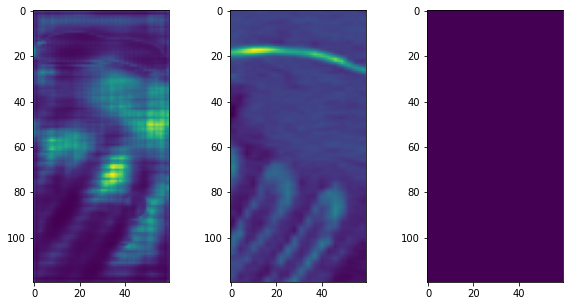

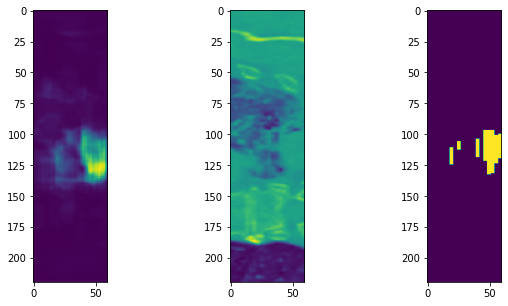

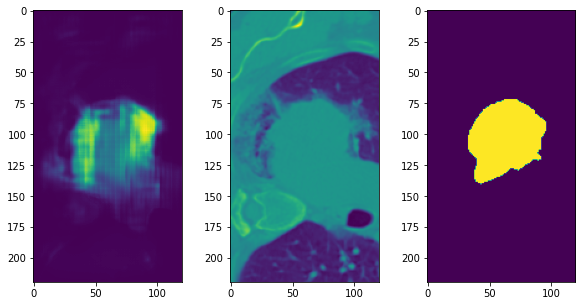

Epoch: 22. Train. loss: 1.032557: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000324]
Epoch: 22. ===> Eval. loss: 1.079037 | DC: 0.147800: 100%|██████████| 34/34 [00:05<00:00,  6.01it/s, gpu_memory=4.46 GB, lr=0.000324]


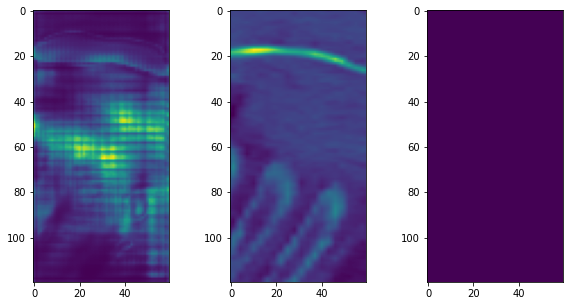

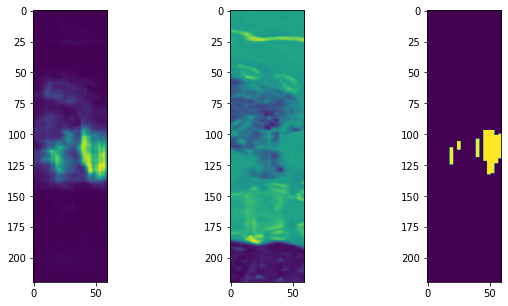

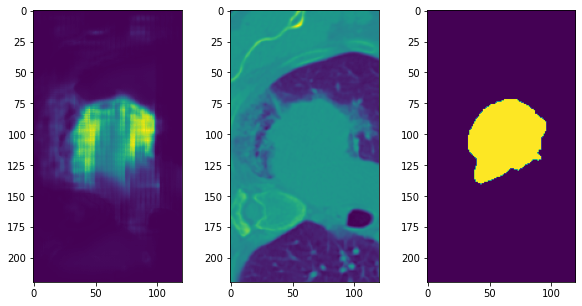

Epoch: 23. Train. loss: 1.027509: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000307]
Epoch: 23. ===> Eval. loss: 1.040264 | DC: 0.394993: 100%|██████████| 34/34 [00:05<00:00,  6.02it/s, gpu_memory=4.46 GB, lr=0.000307]


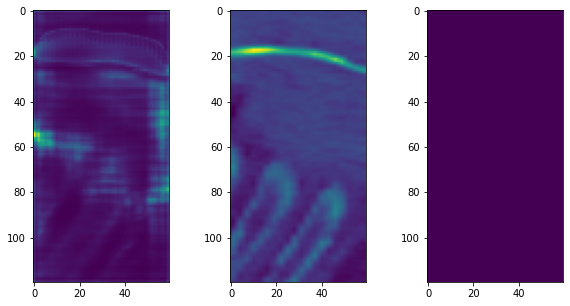

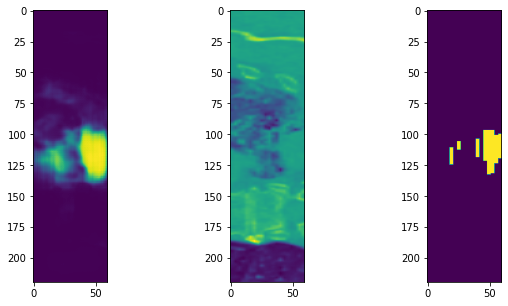

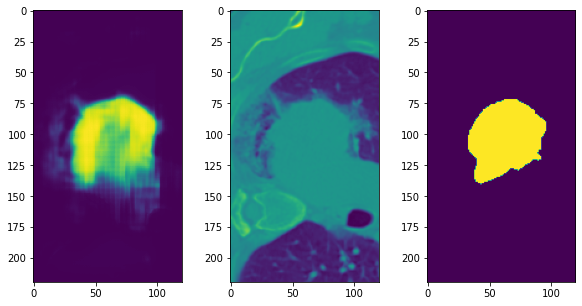

Epoch: 24. Train. loss: 1.025984: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000292]
Epoch: 24. ===> Eval. loss: 1.045686 | DC: 0.408227: 100%|██████████| 34/34 [00:05<00:00,  6.02it/s, gpu_memory=4.46 GB, lr=0.000292]


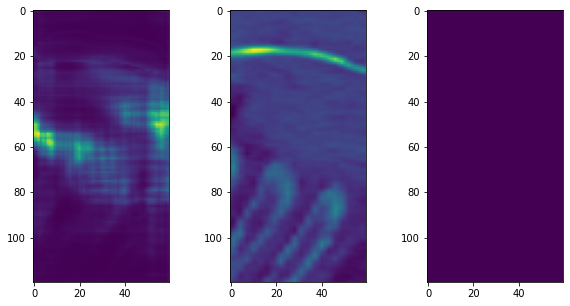

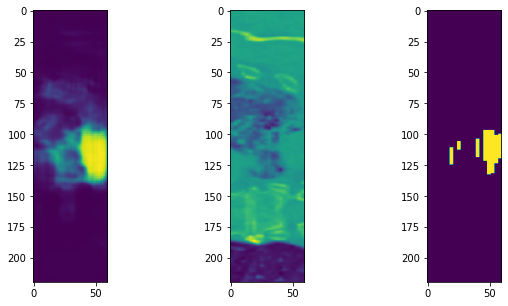

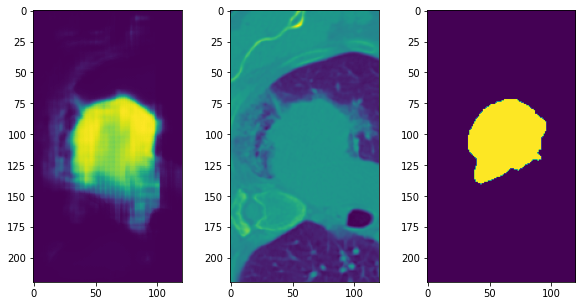

Epoch: 25. Train. loss: 1.016903: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000277]
Epoch: 25. ===> Eval. loss: 1.086585 | DC: 0.374003: 100%|██████████| 34/34 [00:05<00:00,  5.98it/s, gpu_memory=4.46 GB, lr=0.000277]


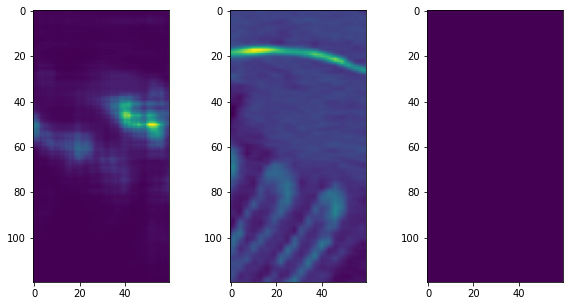

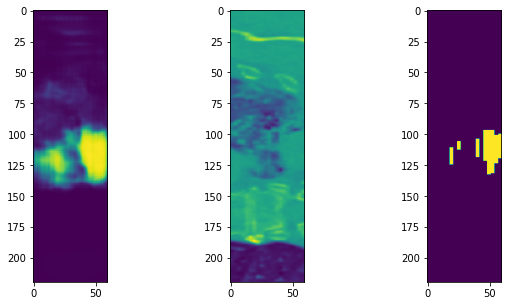

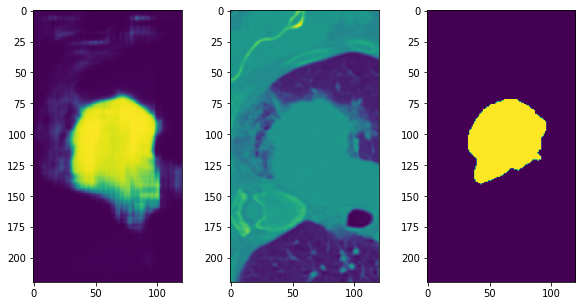

Epoch: 26. Train. loss: 1.014654: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000264]
Epoch: 26. ===> Eval. loss: 1.046576 | DC: 0.409227: 100%|██████████| 34/34 [00:05<00:00,  6.00it/s, gpu_memory=4.46 GB, lr=0.000264]


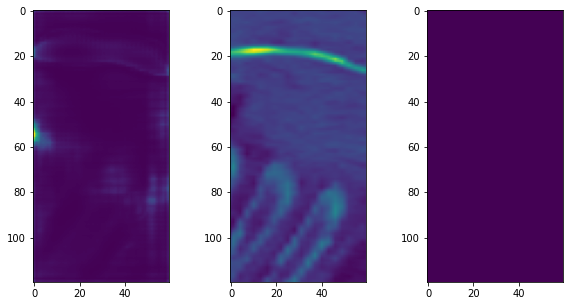

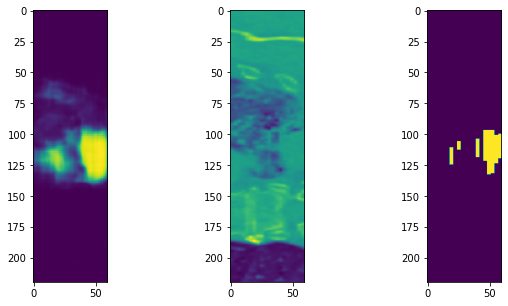

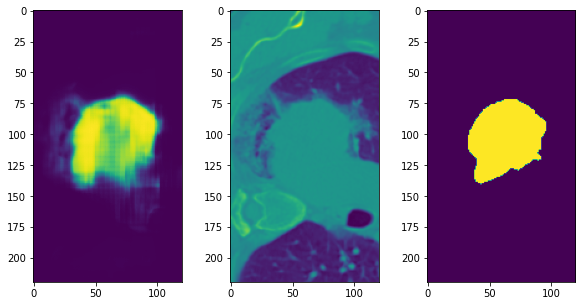

Epoch: 27. Train. loss: 1.012130: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.00025]
Epoch: 27. ===> Eval. loss: 1.041370 | DC: 0.427723: 100%|██████████| 34/34 [00:05<00:00,  5.98it/s, gpu_memory=4.46 GB, lr=0.00025]


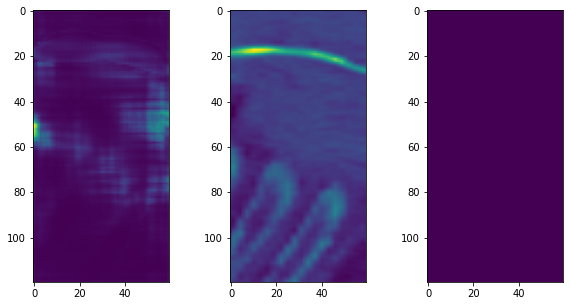

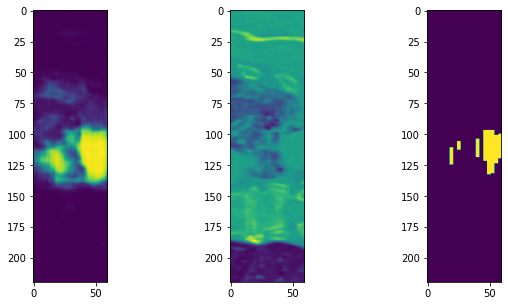

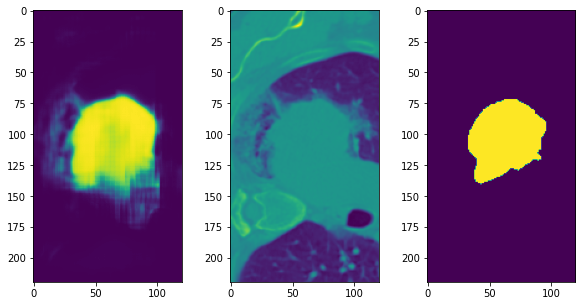

Epoch: 28. Train. loss: 1.015848: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000238]
Epoch: 28. ===> Eval. loss: 1.033675 | DC: 0.438175: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s, gpu_memory=4.46 GB, lr=0.000238]


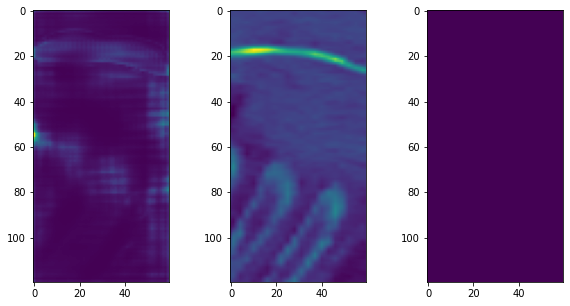

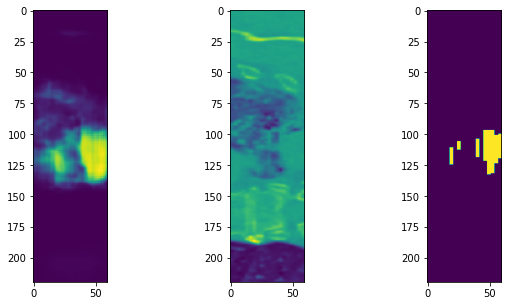

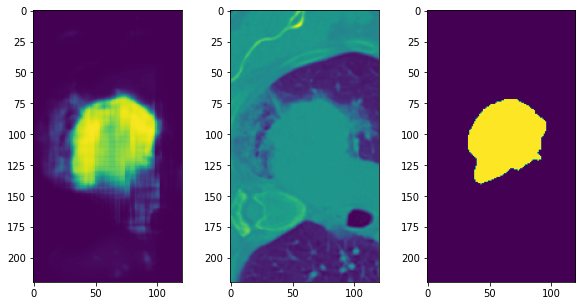

Epoch: 29. Train. loss: 1.011674: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000226]
Epoch: 29. ===> Eval. loss: 1.030074 | DC: 0.419953: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s, gpu_memory=4.46 GB, lr=0.000226]


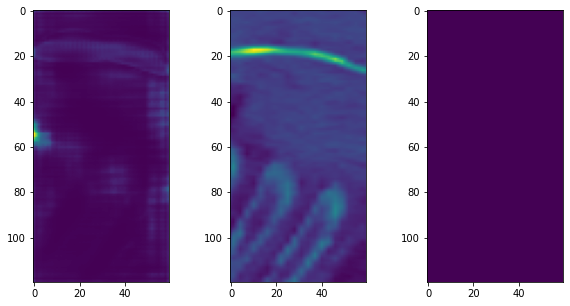

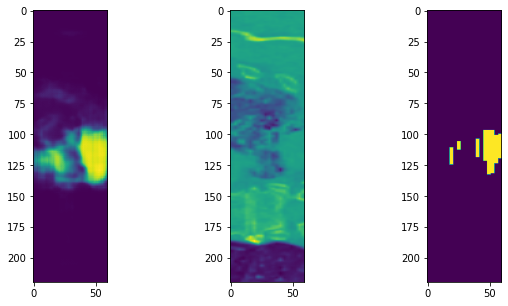

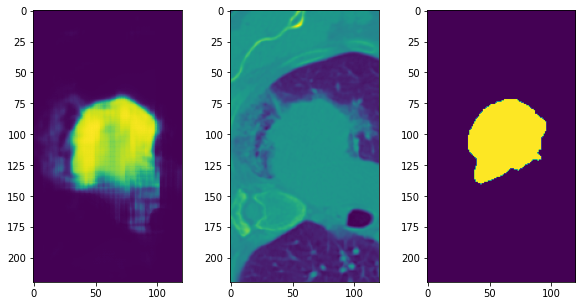

Epoch: 30. Train. loss: 1.010462: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000215]
Epoch: 30. ===> Eval. loss: 1.039299 | DC: 0.417139: 100%|██████████| 34/34 [00:05<00:00,  6.00it/s, gpu_memory=4.46 GB, lr=0.000215]


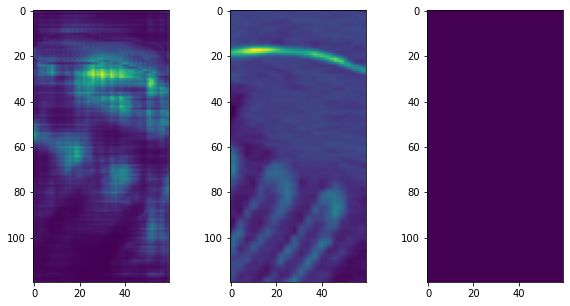

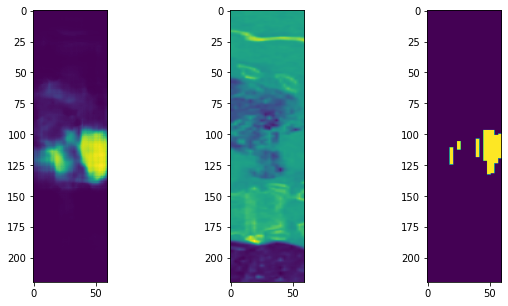

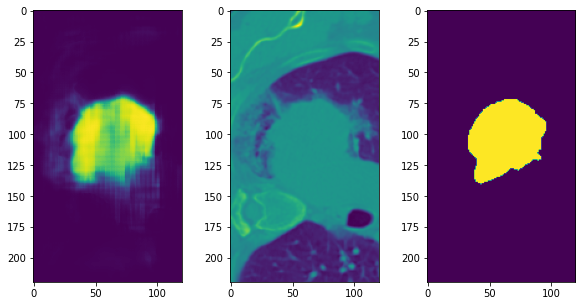

Epoch: 31. Train. loss: 1.006885: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000204]
Epoch: 31. ===> Eval. loss: 1.030656 | DC: 0.398040: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s, gpu_memory=4.46 GB, lr=0.000204]


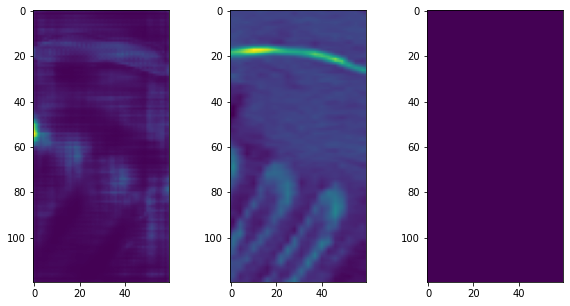

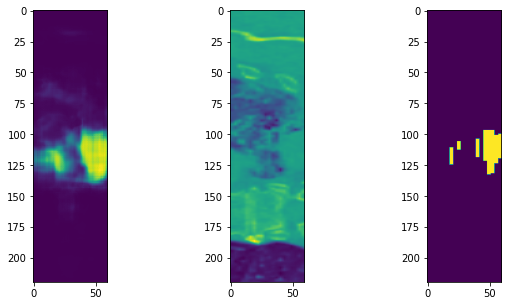

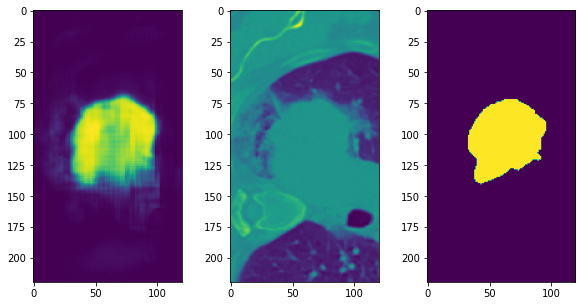

Epoch: 32. Train. loss: 1.008123: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000194]
Epoch: 32. ===> Eval. loss: 1.031413 | DC: 0.372071: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s, gpu_memory=4.46 GB, lr=0.000194]


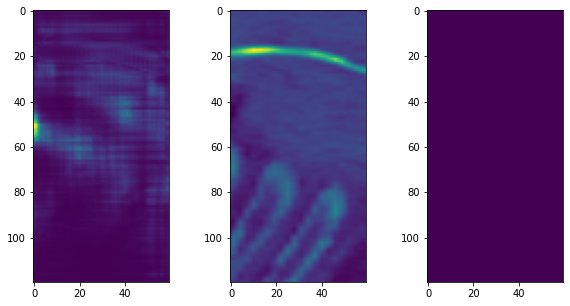

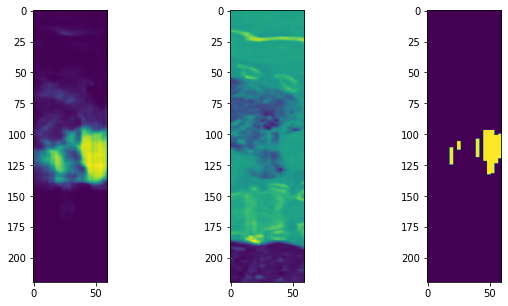

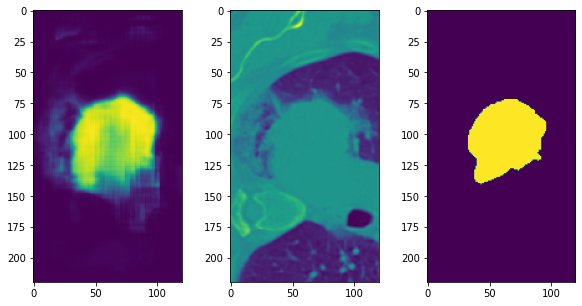

Epoch: 33. Train. loss: 1.006925: 100%|██████████| 135/135 [01:28<00:00,  1.53it/s, gpu_memory=10.39 GB, lr=0.000184]
Epoch: 33. ===> Eval. loss: 1.045616 | DC: 0.410020: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s, gpu_memory=4.46 GB, lr=0.000184]


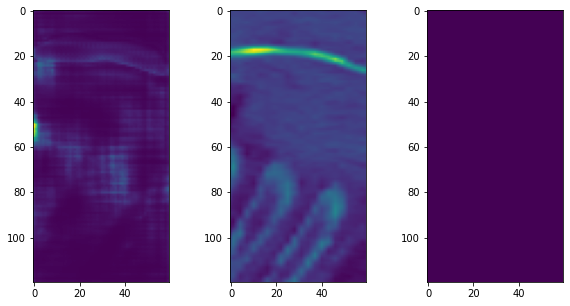

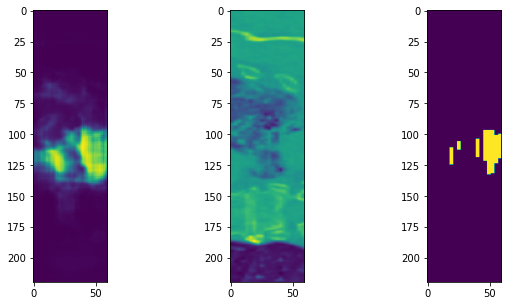

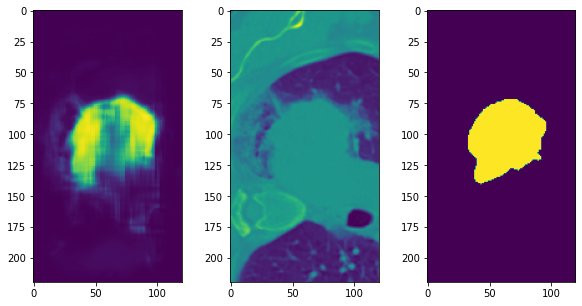

Epoch: 34. Train. loss: 1.006080:   6%|▌         | 8/135 [00:05<01:24,  1.51it/s, gpu_memory=10.39 GB, lr=0.000175]

In [ ]:
cfg = {
    'batch_size': 2,
    'lr': 0.001,
    'gamma': 0.95,
    'seed': 42,
    'n_workers': 4,
    'device' : torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'n_epochs': 200,
    'counter_es': 10, # early stopping
}
main(cfg, "train_Unet", "Unet", False, False)

In [17]:
cfg = {
    'batch_size': 2,
    'lr': 1e-6,
    'gamma': 0.95,
    'seed': 42,
    'n_workers': 2,
    'device' : torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'n_epochs': 100,
    'counter_es': 10, # early stopping
}
main(cfg, "T_Stage", "Unet", False, True)

> SEEDING DONE


Epoch: 00. ===> Eval. CE: 1.313765: 100%|██████████| 42/42 [00:02<00:00, 17.15it/s, gpu_memory=1.70 GB, lr=7.31e-8]


In [ ]:
cfg = {
    'batch_size': 2,
    'lr': 1e-6,
    'gamma': 0.95,
    'seed': 42,
    'n_workers': 2,
    'device' : torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'n_epochs': 100,
    'counter_es': 10, # early stopping
}
main(cfg, "T_Stage", "CNN", False, False)
main(cfg, "T_Stage", "CNN", False, True)

main(cfg, "T_Stage", "Unet", False, False)
main(cfg, "T_Stage", "Unet", False, True)

main(cfg, "T_Stage", "Resnet34", False, False)
main(cfg, "T_Stage", "Resnet34", False, True)

main(cfg, "T_Stage", "Resnet34", True, False)
main(cfg, "T_Stage", "Resnet34", True, True)


In [ ]:
cfg = {
    'batch_size': 2,
    'lr': 1e-6,
    'gamma': 0.95,
    'seed': 42,
    'n_workers': 2,
    'device' : torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'n_epochs': 100,
    'counter_es': 10, # early stopping
}
main(cfg, "Overall_Stage", "CNN", False, False)
main(cfg, "Overall_Stage", "CNN", False, True)

main(cfg, "Overall_Stage", "Unet", False, False)
main(cfg, "Overall_Stage", "Unet", False, True)

main(cfg, "Overall_Stage", "Resnet34", False, False)
main(cfg, "Overall_Stage", "Resnet34", False, True)

main(cfg, "Overall_Stage", "Resnet34", True, False)
main(cfg, "Overall_Stage", "Resnet34", True, True)

In [ ]:
cfg = {
    'batch_size': 2,
    'lr': 1e-5,
    'gamma': 0.95,
    'seed': 42,
    'n_workers': 2,
    'device' : torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'n_epochs': 100,
    'counter_es': 10, # early stopping
}
main(cfg, "Survival_Analysis", "CNN", False, False)
main(cfg, "Survival_Analysis", "Unet", False, False)
main(cfg, "Survival_Analysis", "Resnet34", False, False)
main(cfg, "Survival_Analysis", "Resnet34", True, False)

> SEEDING DONE


Epoch: 26. Train. NLL: 3.808879:  79%|███████▊  | 106/135 [00:46<00:12,  2.32it/s, gpu_memory=7.23 GB, lr=2.64e-6]